# Введение в нейронные сети

## Урок 4. Сверточные нейронные сети

### Практическое задание

1. Попробуйте улучшить точность распознавания образов cifar 10 сверточной нейронной сетью, рассмотренной на уроке. Приложите анализ с описанием того, что улучшает работу нейронной сети, а что ухудшает.

2. Опишите в анализе, какие изменения необходимо было бы внести в получившуюся нейронную сеть, если бы ей нужно было работать не с cifar10, а с MNIST, CIFAR100 и IMAGENET.

### Решение

Сперва рассмотрим исходную модель из урока.

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D

import os
import matplotlib.pyplot as plt

#### Глобальные настройки проекта

In [2]:
# Случайное зерно.
GLOBAL__RANDOM_STATE = 0

# Веса моделей.
PATH__WEIGHTS_BASELINE = r'weights_baseline'
PATH__WEIGHTS_SECOND = r'weights_second'

# установка параметров нейросети
batch_size = 128
num_classes = 10
epochs = 5
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

#### Загрузка данных

In [3]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [4]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=0.5)

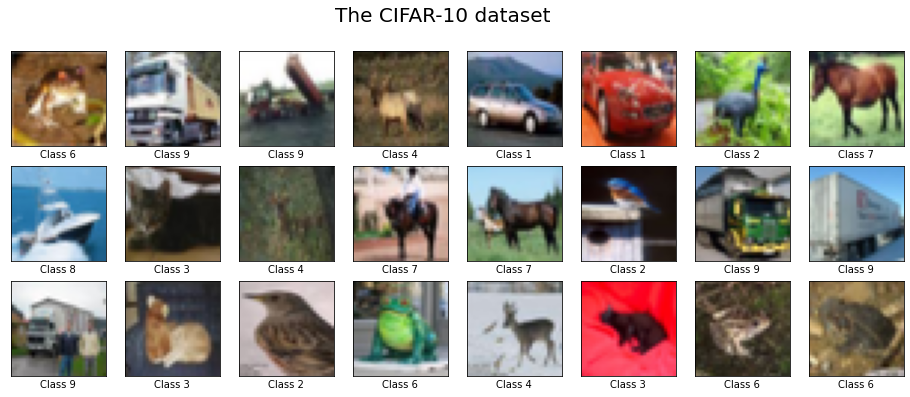

In [5]:
# Проверка: визуализация признаков.
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
fig.suptitle('The CIFAR-10 dataset', fontsize=20)
n = 0
for ax in axes.flat:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.imshow(x_train[n])
    ax.set_xlabel(f'Class {np.where(y_train[n] == 1)[0][0]}')
    n += 1

#### Модель из урока

In [6]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [7]:
# инициализация RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [8]:
%%time

# запуск data augmentation через fit_generator
# model.fit(datagen.flow(x_train,
#                        y_train,
#                        batch_size=batch_size),
#           epochs=epochs,
#           validation_data=(x_test, y_test),
#           workers=4)

# Загрузка весов обученной модели.
model.load_weights(PATH__WEIGHTS_BASELINE)

Wall time: 26.9 ms


In [9]:
# Оценка метрики "accuracy" на обучающей выборке.
model.evaluate(x_train, y_train)

1563/1563 [==============================] - 9s 6ms/step - loss: 1.3786 - accuracy: 0.5057


[1.3786218166351318, 0.5057200193405151]

In [10]:
# Оценка метрики "accuracy" на тестовой выборке.
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.3769 - accuracy: 0.5097


[1.3769423961639404, 0.5097000002861023]

In [11]:
# Сохранение весов лучшей модели с метрикой "accuracy": 0.5097.
# model.save_weights(PATH__WEIGHTS_BASELINE)

Базовая модель из урока достигла точности ~0.51 на тестовой выборке. При этом модель не переобучилась.

Попробуем улучшить модель настройкой гиперпараметров.

#### Улучшенная модель

In [12]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(AveragePooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Dropout(0.1))

# model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(AveragePooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Dropout(0.1))

# полносвязные слои нейронной сети
model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [13]:
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
%%time

# запуск data augmentation через fit_generator
# model.fit(datagen.flow(x_train,
#                        y_train,
#                        batch_size=batch_size),
#           epochs=epochs,
#           validation_data=(x_test, y_test),
#           workers=8)

# Загрузка весов обученной модели.
model.load_weights(PATH__WEIGHTS_SECOND)

Wall time: 27.9 ms


In [15]:
# Оценка метрики "accuracy" на обучающей выборке.
model.evaluate(x_train, y_train)

1563/1563 [==============================] - 10s 7ms/step - loss: 1.3286 - accuracy: 0.5237


[1.3286124467849731, 0.5237399935722351]

In [16]:
# Оценка метрики "accuracy" на тестовой выборке.
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.3286 - accuracy: 0.5176


[1.328640341758728, 0.5175999999046326]

In [17]:
# Сохранение весов лучшей модели с метрикой "accuracy": 0.5176.
# model.save_weights(PATH__WEIGHTS_SECOND)

Настройка гиперпараметров позволила улучшить точность прогноза нейронной сети до ~0.52. Следующие факторы благоприятно сказались на эффективности модели:
- изменение стратегии пуллингово слоя с "максимальный" на "усреднённый". Данная настройка позволила фиксировать не только максимальные фильтры, но и промежуточные;
- ядра второго набора свёрточных слоёв были увеличены с размерности 3х3 до 5х5, чтобы модель могла построить более высокоабстрактные шаблоны;
- нейроны в полносвязном слое были распределены в несколько слоёв, что позволило модели лучше выявить нелинейные зависимости между признаками;
- вероятность потери информации между слоями была снижена, так как модель не демонстрировала склонность к переобучению.

Также были установлены факторы, которые приводили к снижению качества прогноза:
- одновременное использование различных функций активации;
- увеличение всех ядер свёрточных слоёв;
- создание большей последовательности свёрточных слоёв.

#### Использование нейронной сети с другими данными

В случае с датасетом <code>MNIST</code> потребуется упрощение текущей модели. Данный набор данных содержит только чёрно-белые символы, поэтому не потребуется размерность глубины цвета. Также символы представляют собой менее сложную закономерность, чем изображения различных объектов, так что в целях оптимизации возможно было бы упростить свёрточные и полносвязные слои.

Набор данных <code>CIFAR100</code> содержит гораздо больше классов целевой переменной, поэтому потребуется усовершенствование полносвязных слоёв. Также, чтобы нейросеть смогла обнаружить больше признаков, возможно, потребуется больше свёрточных слоёв.

Данные <code>IMAGENET</code> представляют собой наиболее сложную задачу, так как содержат более 14 миллионов объектов и более 20 тысяч классов. Для решения данной задачи потребовалась бы значительная модернизация текущей модели: обширные свёрточные и пуллинговые слои должны были бы выявить достаточно признаков для классификации, а анализ признаков потребовал бы большого числа полносвязных слоёв.